# Transfer Learning with TensorFlow Part 2: Fine-tuning 

In the previous notebook, we covered transfer learning feature extraction. Now it's time to learn about a new kind of transfer learning: fine-tuning

# Creating Helper functions 
in the previous notebooks we've created a bunch of helper functions, now we could rewrite them all or we could create a helper function script.

Its a good idea to put functions you'll want to use again in a script you can download and import into youru notebooks (or elsewhere). 

We've done this for some of the functions we've used previously

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-22 13:33:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-22 13:33:19 (64.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Improt helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


# Let's get some data
This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem 

In [ ]:
# Get 10% of training data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2022-07-22 13:33:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   247MB/s    in 0.7s    

2022-07-22 13:33:27 (247 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[5.28571415e+00 6.28571415e+00 1.28571439e+00]
   [5.38265276e+00 6.38265276e+00 1.38265264e+00]
   [7.20918369e+00 8.20918369e+00 3.20918369e+00]
   ...
   [5.82753944e+01 4.75509872e+01 3.05664425e+01]
   [4.57855835e+01 4.49539833e+01 4.47857285e+01]
   [2.14233227e+01 2.57243996e+01 4.52500534e+01]]

  [[5.42857122e+00 6.42857122e+00 1.42857146e+00]
   [5.35204029e+00 6.35204029e+00 1.35204041e+00]
   [7.35714245e+00 8.35714245e+00 3.35714269e+00]
   ...
   [7.38979187e+01 6.84694366e+01 7.48572540e+01]
   [5.86885872e+01 6.21886253e+01 8.04744339e+01]
   [3.20662498e+01 3.91581497e+01 7.31072617e+01]]

  [[1.12142859e+01 1.22142859e+01 7.21428633e+00]
   [1.14693880e+01 1.24693880e+01 7.46938753e+00]
   [1.43571434e+01 1.53571434e+01 1.03571434e+01]
   ...
   [7.52857132e+01 7.98622818e+01 1.09244942e+02]
   [6.55661316e+01 7.81681900e+01 1.11999886e+02]
   [3.12344093e+01 4.56477585e+01 9.00100479e+01]]

  ...

  [[2.49285984e+01 1.56479893e+01 6.64798880e+00]
   [2

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The seqential API is straight-forward, it runs our models in sequential order, but the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create base model with tf.keras.EfficientNet
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the uunderlying pre-trained weights aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs (however you do not need to do it for EfficientNet)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")


# 6. Average pool the outputs of the base model (aggregate all the most important information. reduce the nmber of compuatations)
x = tf.keras.layers.GlobalAveragePooling2D(name ='global_average_pooling_layer')(x)
print(f"Shape after global average pooling 2D: {x.shape}")

# 7. Create the output activation layer 
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model 
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model 
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10 . Fit the model  and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data_10_percent,
                        validation_steps = len(test_data_10_percent),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning", 
                                                                 experiment_name= "model_0")])


16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20220722-133334
Epoch 1/5
24/24 [==============================] - 150s 6s/step - loss: 1.8596 - accuracy: 0.4147 - val_loss: 1.3322 - val_accuracy: 0.7168
Epoch 2/5
24/24 [==============================] - 174s 7s/step - loss: 1.1205 - accuracy: 0.7600 - val_loss: 0.9163 - val_accuracy: 0.7976
Epoch 3/5
24/24 [==============================] - 175s 8s/step - loss: 0.8259 - accuracy: 0.8107 - val_loss: 0.7464 - val_accuracy: 0.8264
Epoch 4/5
24/24 [==============================] - 174s 8s/step - loss: 0.6803 - accuracy: 0.8427 - val_loss: 0.6609 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 144s 6s/step - loss: 0.5792 - accuracy: 0.8733 - val_loss: 0.6057 - val_accuracy: 0.8440


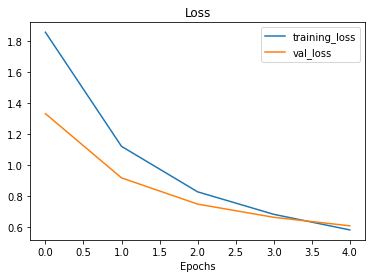

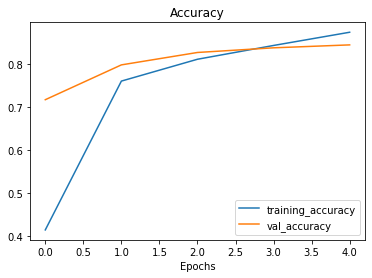

In [ ]:
# 11. Visualize loss curves
plot_loss_curves(history_0)

In [ ]:
# 12. Check model summary 
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# 13. Evaluate the model 
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 110s 1s/step - loss: 0.6057 - accuracy: 0.8440


[0.6057395339012146, 0.843999981880188]

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer... 

We have a tensor after our model goes through `base_model` of shape(None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [ ]:
# Define the input shape 
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]



In [ ]:
# Pass the random tensor through a GlobalAveragePooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f" 2D global average pooled random tensor:\n {global_average_pooled_tensor} \n")

 2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]] 



In [ ]:
tf.reduce_mean(input_tensor, axis =[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

## Running a series of transfer learning experiments 

Let's try a different model using 1% of the the training data 

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation 

2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation 

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation 

4. `model_4` - use fine tuning transfer learning on 100% of the training data with data augmentation 

All models will be tested on the same test data for fair comparison

### Model 1

In [ ]:
# Get 10% of training data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_1_percent.zip')

--2022-07-22 13:51:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   237MB/s    in 0.5s    

2022-07-22 13:51:58 (237 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test directory paths
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_1_percent,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Adding data augmentation right into the model 

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

Off the top of our heads, after reading the keras_pre_processing_layers documentation we can see the benefits are 
* Preprocessing of images (augmenting them) happens on the GPU (much faster) than the CPU (like the ImageDataGenerator method)
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create data augmentation stage with horizontal flipping , rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


#### Visualize our data augmentation layer (and see what happens to our data)

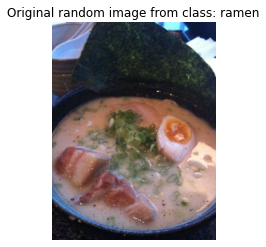

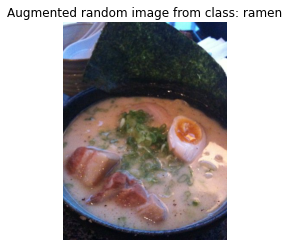

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);



#### Model 1: Feature Extraction Transfer Learning on 1% of the data with data augmentaion

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentaion) and not train it
x = base_model(x, training = False)

# pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output 
outputs = layers.Dense(10, activation = 'softmax', name = "output_layer")(x)

model_1 = keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                #Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                         experiment_name = '1_percent_data_aug')]
                                )


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220722-164128
Epoch 1/5
3/3 [==============================] - 53s 22s/step - loss: 2.4213 - accuracy: 0.1143 - val_loss: 2.2213 - val_accuracy: 0.2122
Epoch 2/5
3/3 [==============================] - 45s 21s/step - loss: 2.1406 - accuracy: 0.2714 - val_loss: 2.1099 - val_accuracy: 0.2895
Epoch 3/5
3/3 [==============================] - 44s 21s/step - loss: 1.9901 - accuracy: 0.4000 - val_loss: 1.9905 - val_accuracy: 0.3717
Epoch 4/5
3/3 [==============================] - 33s 16s/step - loss: 1.8122 - accuracy: 0.5714 - val_loss: 1.9029 - val_accuracy: 0.4243
Epoch 5/5
3/3 [==============================] - 45s 22s/step - loss: 1.6394 - accuracy: 0.6857 - val_loss: 1.7980 - val_accuracy: 0.4951


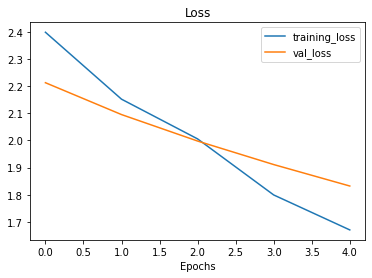

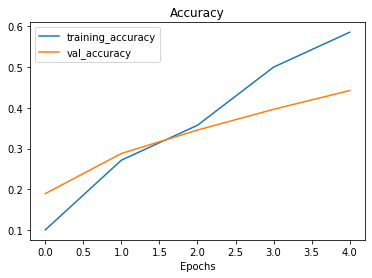

In [ ]:
# Plot loss curves 
plot_loss_curves(history_1_percent)

In [ ]:
  model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Model 2: Feature extraction with data augmentation on 10% of the Training data

In [ ]:
# Get 10% of data
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# set data inputs 
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent =tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode = 'categorical',
                                                                           image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = 'categorical',
                                                               image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow.python.eager.backprop import flatten_nested_indexed_slices
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Build data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2)
], name = 'data_augmentatin')

# Setup the input shape
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the inputs and ouutputs (including the layers between)
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training =False) # pass augmented images to base model but keep it in inference mode, and also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name ='global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation = 'softmax', name = "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile 
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit 
history_2_10_percent  = model_2.fit(train_data_10_percent,
                                    epochs = 5,
                                    steps_per_epoch = len(train_data_10_percent),
                                    validation_data = test_data,
                                    validation_steps = len(test_data),
                                    callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                             experiment_name = '10_percent_data_aug')])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220722-164745
Epoch 1/5
24/24 [==============================] - 195s 8s/step - loss: 2.0229 - accuracy: 0.2987 - val_loss: 1.4683 - val_accuracy: 0.6392
Epoch 2/5
24/24 [==============================] - 183s 8s/step - loss: 1.3739 - accuracy: 0.6560 - val_loss: 1.0511 - val_accuracy: 0.7572
Epoch 3/5
24/24 [==============================] - 167s 7s/step - loss: 1.0813 - accuracy: 0.7267 - val_loss: 0.8613 - val_accuracy: 0.7900
Epoch 4/5
24/24 [==============================] - 167s 7s/step - loss: 0.9312 - accuracy: 0.7840 - val_loss: 0.7521 - val_accuracy: 0.8080
Epoch 5/5
24/24 [==============================] - 164s 7s/step - loss: 0.7952 - accuracy: 0.7853 - val_loss: 0.6982 - val_accuracy: 0.8136


In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

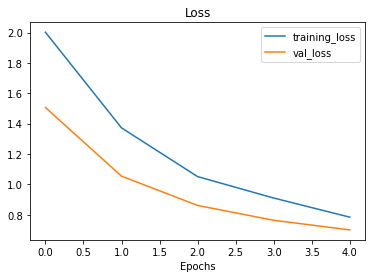

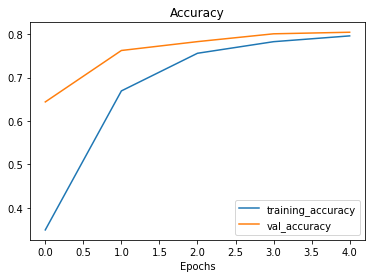

In [ ]:
# Plot loss curves
plot_loss_curves(history_2_10_percent)

### Creating a Model Checkpoint callback

The modelcheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# set checkpoint path 
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a modelcheckpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only =True,
                                                         save_best_only = False,
                                                         save_freq = "epoch")

In [ ]:
# Fit model with modelcheckpoint call back
history_2_10_percent = model_2.fit(train_data_10_percent,
                                    epochs = 5,
                                    steps_per_epoch = len(train_data_10_percent),
                                    validation_data = test_data,
                                    validation_steps = len(test_data),
                                    callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                             experiment_name = '10_percent_data_aug'), checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220722-170310
Epoch 1/5
24/24 [==============================] - 182s 8s/step - loss: 0.7061 - accuracy: 0.8253 - val_loss: 0.6508 - val_accuracy: 0.8212
Epoch 2/5
24/24 [==============================] - 168s 7s/step - loss: 0.6784 - accuracy: 0.8333 - val_loss: 0.6144 - val_accuracy: 0.8272
Epoch 3/5
24/24 [==============================] - 167s 7s/step - loss: 0.6327 - accuracy: 0.8373 - val_loss: 0.5894 - val_accuracy: 0.8312
Epoch 4/5
24/24 [==============================] - 165s 7s/step - loss: 0.5678 - accuracy: 0.8627 - val_loss: 0.5762 - val_accuracy: 0.8300
Epoch 5/5
24/24 [==============================] - 166s 7s/step - loss: 0.5527 - accuracy: 0.8573 - val_loss: 0.5573 - val_accuracy: 0.8344


#### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint_callback

In [ ]:
# Load in saved model weights and evaluate model 
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 120s 2s/step - loss: 0.5643 - accuracy: 0.8268


### Model 3: Fine-tuning on 10% of data

Fine tuning usually works best *after* training a feature extraction model for a few epochs with large amount of custom data

In [ ]:
model_2.layers

In [ ]:
# are our layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1997f79390> True
<keras.engine.sequential.Sequential object at 0x7f1993527ed0> True
<keras.engine.functional.Functional object at 0x7f19931de2d0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1997fe9210> True
<keras.layers.core.dense.Dense object at 0x7f199306d0d0> True


In [ ]:
# what layers are in our base_model
for i , layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are in our base models 
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable to true
base_model.trainable = True
# Freeze all layers except for the last 10 
for layer in base_model.layers[:-10]:
  layer.trainable  =False

  # Recompile ( we have to recompile our models everytime we make a change)
  model_2.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), # when fine tuning you typically want to lower the learning rate by 10x 
                  metrics =['accuracy'])

In [ ]:
# Check which layers are tunable (trainable)
for layer_number , layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
initial_epoch = 5
fine_tune_epochs = initial_epoch + 5

# Refit the model (same as model_2 expect with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs, 
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_2_10_percent.epoch[-1], # start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name='transfer_learning',
                                                                                        experiment_name = '10_percent_fine_tune_last_10')])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220722-162953
Epoch 5/10
24/24 [==============================] - 95s 4s/step - loss: 0.3208 - accuracy: 0.8853 - val_loss: 0.3425 - val_accuracy: 0.8914
Epoch 6/10
24/24 [==============================] - 81s 3s/step - loss: 0.2445 - accuracy: 0.9320 - val_loss: 0.3236 - val_accuracy: 0.8931
Epoch 7/10
24/24 [==============================] - 88s 4s/step - loss: 0.2263 - accuracy: 0.9307 - val_loss: 0.3544 - val_accuracy: 0.8882
Epoch 8/10
24/24 [==============================] - 88s 4s/step - loss: 0.2199 - accuracy: 0.9387 - val_loss: 0.3277 - val_accuracy: 0.8931
Epoch 9/10
24/24 [==============================] - 89s 4s/step - loss: 0.1953 - accuracy: 0.9453 - val_loss: 0.3729 - val_accuracy: 0.8816
Epoch 10/10
24/24 [==============================] - 85s 4s/step - loss: 0.1859 - accuracy: 0.9533 - val_loss: 0.3391 - val_accuracy: 0.8914


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine tuned )
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 116s 1s/step - loss: 0.4950 - accuracy: 0.8324


The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare the running `fit()` with another

In [ ]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Get new history measurements
  new_acc = new_history.history["accuracy"]
  new_loss = new_history.history['loss']

  new_val_acc = new_history.history['val_accuracy']
  new_val_loss = new_history.history['val_loss']

  # combine original history
  total_acc = acc + new_acc
  total_loss = loss + new_loss
  total_val_loss = val_loss + new_val_loss
  total_val_acc = val_acc + new_val_acc

  # Make plots for accuracy 
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = "Training accuracy")
  plt.plot(total_val_acc, label = "Val accuracy")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label = "Start fine tuning")
  plt.legend(loc = 'lower right')
  plt.title("Training and validation histories")

  # Make plots for loss 
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label = "Training loss")
  plt.plot(total_val_loss, label = "Val loss")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label = "Start fine tuning")
  plt.legend(loc = 'upper right')
  plt.title("Training and loss histories")

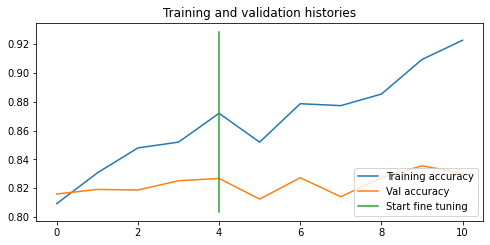

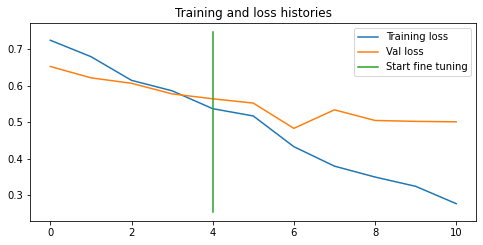

In [ ]:
compare_historys(history_2_10_percent, history_fine_10_percent_data_aug, initial_epochs=5)

### Model 4: Fine tuning an existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 with all iamges
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

--2022-07-22 14:44:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   120MB/s    in 4.0s    

2022-07-22 14:44:22 (124 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# setup training and test dir
train_dir_all_data = '10_food_classes_all_data/train'
test_dir_all_data = '10_food_classes_all_data/test'

In [ ]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = 'categorical',
                                                                                 image_size =IMG_SIZE)

test_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all_data,
                                                                                 label_mode = 'categorical',
                                                                                 image_size =IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


To train a fine_tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [ ]:
# load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 132s 2s/step - loss: 0.5643 - accuracy: 0.8268


[0.5642940402030945, 0.8267999887466431]

The previous steps might seem confusiong but all we've done is 

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2_ and we saved the model's weights using `ModelCheckpoint` callback)

2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)

3. Save the results and training log each time

4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4) 

In [ ]:
# Check which layers are tunable in the whole model 
for layer_number , layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentatin True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficentnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile 
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ['accuracy'])

# Fit the model
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                            epochs = fine_tune_epochs,
                            validation_data = test_data,
                            validation_steps = int(0.25 * len(test_data)),
                            initial_epoch = history_2_10_percent.epoch[-1],
                            callbacks = [create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name = 'full_10_classes_fine_tuning_last_10')] 

                            )


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tuning_last_10/20220722-144647
Epoch 5/10
235/235 [==============================] - 519s 2s/step - loss: 0.6866 - accuracy: 0.7771 - val_loss: 0.4421 - val_accuracy: 0.8487
Epoch 6/10
235/235 [==============================] - 481s 2s/step - loss: 0.5806 - accuracy: 0.8116 - val_loss: 0.3965 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 478s 2s/step - loss: 0.5171 - accuracy: 0.8347 - val_loss: 0.3379 - val_accuracy: 0.8865
Epoch 8/10
235/235 [==============================] - 485s 2s/step - loss: 0.4746 - accuracy: 0.8500 - val_loss: 0.3765 - val_accuracy: 0.8750
Epoch 9/10
235/235 [==============================] - 501s 2s/step - loss: 0.4383 - accuracy: 0.8569 - val_loss: 0.3242 - val_accuracy: 0.9013
Epoch 10/10
235/235 [==============================] - 518s 2s/step - loss: 0.4031 - accuracy: 0.8680 - val_loss: 0.3321 - val_accuracy: 0.8931


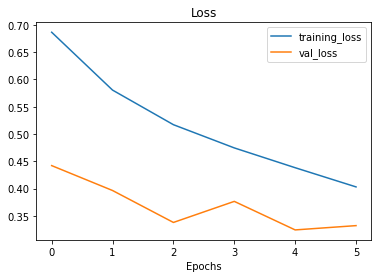

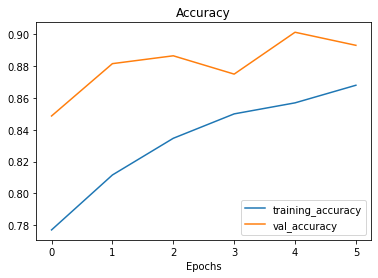

In [ ]:
plot_loss_curves(history_fine_10_classes_full)

In [ ]:
# let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 138s 2s/step - loss: 0.3074 - accuracy: 0.9016


[0.30742841958999634, 0.9016000032424927]

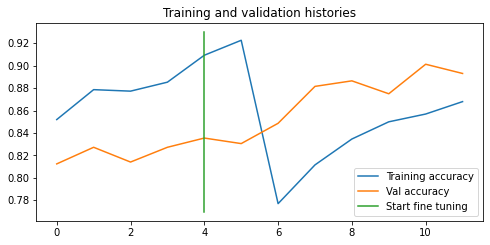

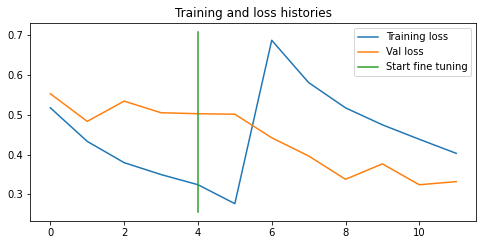

In [ ]:
compare_historys(original_history= history_fine_10_percent_data_aug, new_history=history_fine_10_classes_full)

## Viewing our experiment data on TensorBoard

> Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be ~4 models)
!tensorboard dev upload --logdir ./transfer_learning\
  --name "Transfer Learning Experiments with 10 Food101 class  "\
  --description "A series of different transfer learning experimetns with varying amount of data & fine tuning"\
  --one_shot # exits the uploader when its finished

2022-07-22 17:18:19.053458: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/f5NBmwXATnqc0tdlglW9Og/

[2022-07-22T17:18:19] Started scanning logdir.
[2022-07-22T17:18:25] Total uploaded: 192 scalars, 0 tensors, 6 binary objects (4.9 MB)
[2022-07-22T17:18:25] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/f5NBmwXATnqc0tdlglW9Og/


In [ ]:
# To delete an experiment
#!tensorboard dev delete --experiment_id muDynAD9QGm4D8PWXzxCQA